In [129]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize
from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [130]:
second_sales = "EU_Sales"

# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", second_sales]
data = data.filter(items=columns_used_for_clustering)

# compute stats for each column
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})

# standardization
standardize(data, columns_used_for_clustering, columns_stats)

# outlier detection
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

# drop outliers from the dataset
data = drop_outliers_from_dataset(data, outliers)

# de-standardization
de_standardize(data, columns_used_for_clustering, columns_stats)

### Classification - NA_Sales prediction using other sales and Critic_Score

In [131]:
# create artificial clusters
data["cluster"] = 0
data.loc[data["NA_Sales"] > 0.2, "cluster"] = 1
data.loc[data["NA_Sales"] > 0.7, "cluster"] = 2

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

Number of entries in each cluster:
0    1232
1    1051
2     412
Name: cluster, dtype: int64


### Display clusters and information about them

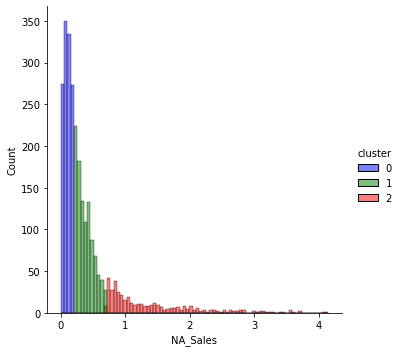

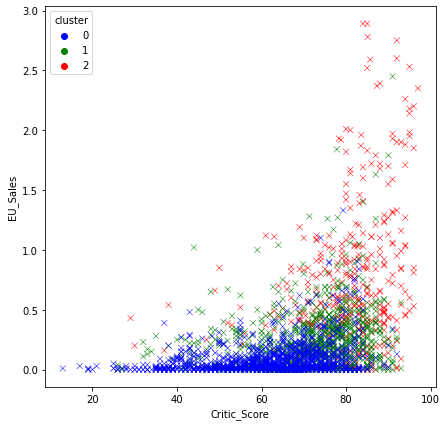

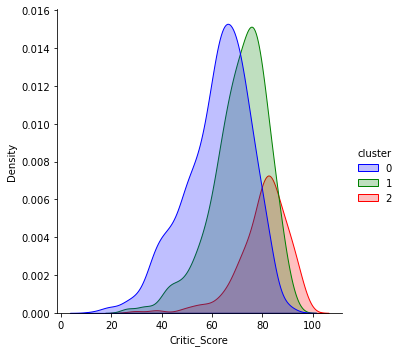

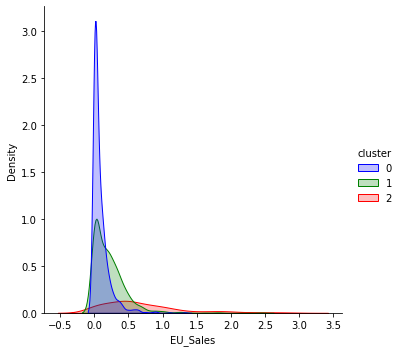

In [132]:
palette = ["blue", "green", "red"]

sns.displot(data, x="NA_Sales", hue="cluster", palette=palette)
plt.show()

sns.scatterplot(data=data, x="Critic_Score", y=second_sales, hue="cluster", palette=palette, marker='x')
plt.show()

sns.displot(data, x="Critic_Score", hue="cluster", kind="kde", palette=palette, fill=True)
sns.displot(data, x=second_sales, hue="cluster", kind="kde", palette=palette, fill=True)


### Drop column with NA_Sales - it should not be used in the classification, standardize data

In [133]:
data = data.drop(["NA_Sales"], axis=1)
standardize(data, [second_sales, "Critic_Score"], columns_stats)

### Perform classification using KNN, with different numbers of neighbours

K = 1 - correct: 0.5573283858998145
K = 2 - correct: 0.5651205936920223
K = 3 - correct: 0.5673469387755102
K = 4 - correct: 0.6014842300556587
K = 5 - correct: 0.5884972170686457
K = 6 - correct: 0.6003710575139146
K = 7 - correct: 0.6055658627087198
K = 8 - correct: 0.6152133580705009
K = 9 - correct: 0.6181818181818182
K = 10 - correct: 0.6144712430426716
K = 11 - correct: 0.6233766233766234
K = 12 - correct: 0.6115027829313544
K = 13 - correct: 0.6256029684601113
K = 14 - correct: 0.6192949907235622
K = 15 - correct: 0.6181818181818182
K = 16 - correct: 0.6267161410018552
K = 17 - correct: 0.6256029684601113
K = 18 - correct: 0.6293135435992578
K = 19 - correct: 0.6230055658627087
K = 20 - correct: 0.624860853432282
K = 21 - correct: 0.6226345083487941
K = 22 - correct: 0.6181818181818182
K = 23 - correct: 0.6226345083487941
K = 24 - correct: 0.6256029684601113
K = 25 - correct: 0.624860853432282
K = 26 - correct: 0.625974025974026
K = 27 - correct: 0.6263450834879406
K = 28 - corr

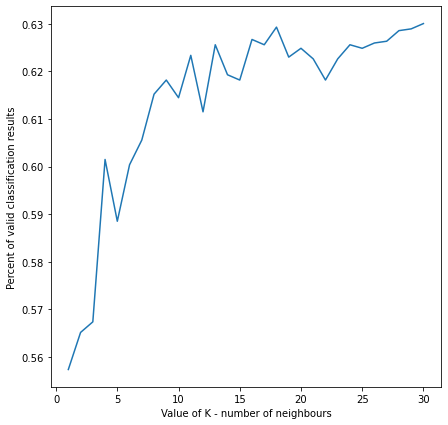

In [134]:
qualities = []
for number_of_neighbours in range(1, 31):
    classification_quality, _ = k_neighbours_leave_one_out(data, "cluster", number_of_neighbours)
    print("K = {} - correct: {}".format(number_of_neighbours, classification_quality))
    qualities.append(classification_quality)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), qualities)
plt.show()

### Perform classification using other methods: decision tree

In [135]:
classification_quality, _ = decision_tree_leave_one_out(data, "cluster")
print("Accuracy for leave one out - decision tree: {}".format(classification_quality))

Accuracy for leave one out - decision tree: 0.5818181818181818


### Split the dataset into training and testing parts for further studies

In [136]:
X = data[["Critic_Score", second_sales]].to_numpy()
Y = data["cluster"].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

training_data = pd.DataFrame(np.concatenate((X_train, np.expand_dims(Y_train, axis=1)), axis=1),
                             columns=["Critic_Score", second_sales, "cluster"])
training_data["cluster"] = training_data["cluster"].astype(int)

testing_data = pd.DataFrame(np.concatenate((X_test, np.expand_dims(Y_test, axis=1)), axis=1),
                            columns=["Critic_Score", second_sales, "cluster"])
testing_data["cluster"] = testing_data["cluster"].astype(int)

### Perform classification using KNN, for different numbers of neighbours

K = 1 - test data score: 0.5250463821892394, training data score: 0.859925788497217
K = 2 - test data score: 0.5602968460111317, training data score: 0.7555658627087198
K = 3 - test data score: 0.5473098330241187, training data score: 0.7518552875695733
K = 4 - test data score: 0.5807050092764379, training data score: 0.7230983302411874
K = 5 - test data score: 0.5862708719851577, training data score: 0.7142857142857143
K = 6 - test data score: 0.601113172541744, training data score: 0.6920222634508348
K = 7 - test data score: 0.5899814471243042, training data score: 0.6989795918367347
K = 8 - test data score: 0.6029684601113172, training data score: 0.6887755102040817
K = 9 - test data score: 0.601113172541744, training data score: 0.6855287569573284
K = 10 - test data score: 0.6048237476808905, training data score: 0.6781076066790352
K = 11 - test data score: 0.6159554730983302, training data score: 0.6743970315398887
K = 12 - test data score: 0.614100185528757, training data score: 

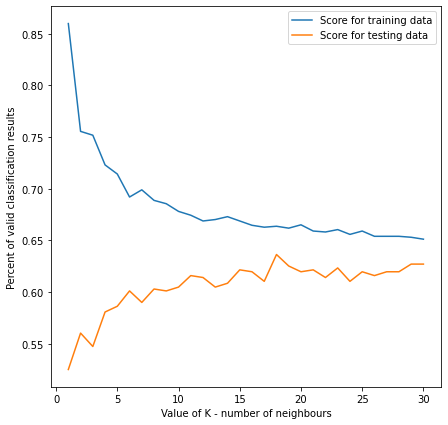

In [137]:
accuracy_test = []
accuracy_train = []
for number_of_neighbours in range(1, 31):
    classifier = KNeighborsClassifier(n_neighbors=number_of_neighbours)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("K = {} - test data score: {}, training data score: {}".format(number_of_neighbours, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), accuracy_train, label="Score for training data")
plt.plot(range(1, 31), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using KNN, for K = 15

Accuracy for testing data: 0.62152133580705
Accuracy for training data: 0.6688311688311688


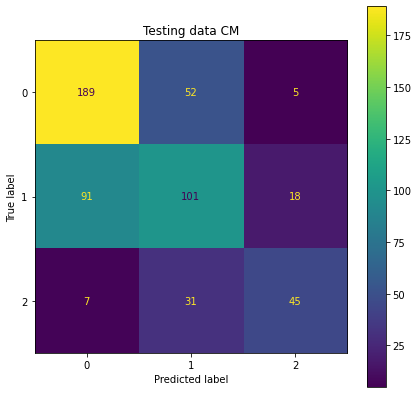

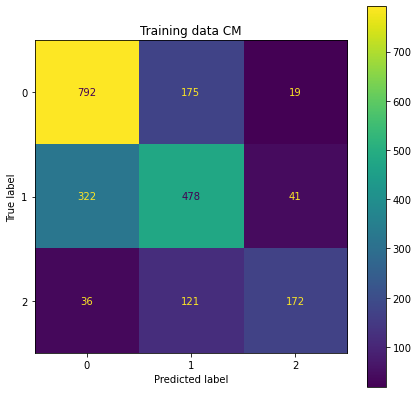

In [138]:
classifier = KNeighborsClassifier(n_neighbors=15)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using decision tree for different max depths

Max depth = 1 - test data score: 0.5695732838589982, training data score: 0.5746753246753247
Max depth = 2 - test data score: 0.6029684601113172, training data score: 0.6280148423005566
Max depth = 3 - test data score: 0.6196660482374768, training data score: 0.648886827458256
Max depth = 4 - test data score: 0.6178107606679035, training data score: 0.6563079777365491
Max depth = 5 - test data score: 0.6289424860853432, training data score: 0.6692949907235621
Max depth = 6 - test data score: 0.62152133580705, training data score: 0.687847866419295
Max depth = 7 - test data score: 0.6066790352504638, training data score: 0.6989795918367347
Max depth = 8 - test data score: 0.5955473098330241, training data score: 0.7217068645640075
Max depth = 9 - test data score: 0.5936920222634509, training data score: 0.7425788497217068
Max depth = 10 - test data score: 0.5936920222634509, training data score: 0.7755102040816326


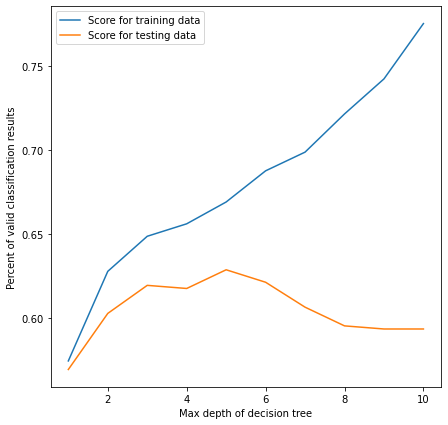

In [139]:
accuracy_test = []
accuracy_train = []
for max_depth in range(1, 11):
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("Max depth = {} - test data score: {}, training data score: {}".format(max_depth, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Max depth of decision tree")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 11), accuracy_train, label="Score for training data")
plt.plot(range(1, 11), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using decision tree for max depth = 3

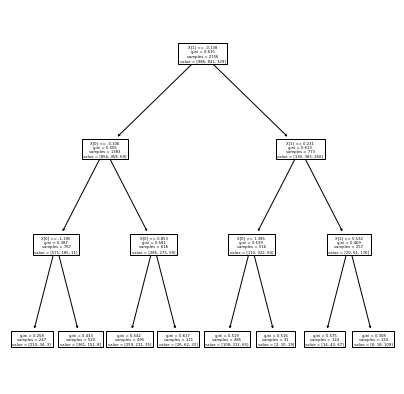

Accuracy for testing data: 0.6196660482374768
Accuracy for training data: 0.648886827458256


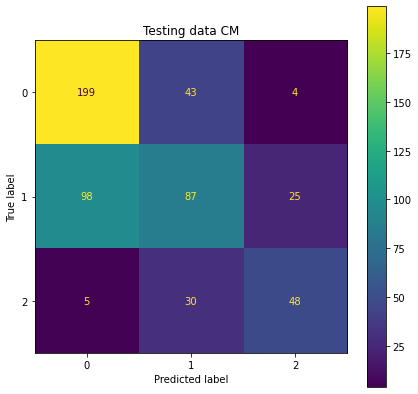

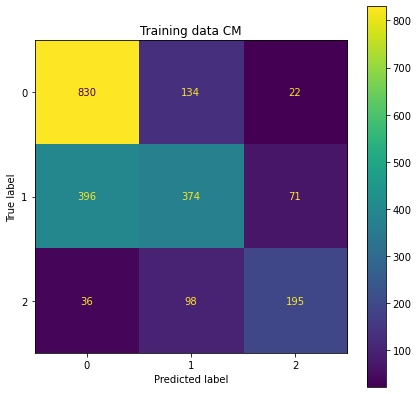

In [140]:
# Note: reducing the depth of this tree has no significant impact on the testing score - only on the training
# score (and even there the impact is not that big) - this is because the tree is "over-fitting"
classifier = tree.DecisionTreeClassifier(max_depth=3)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])
tree.plot_tree(classifier)
plt.show()

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using kernel density estimators

#### Use cross-validation to get proper bandwidths

In [141]:
bandwidths_for_classes = []
for cl in range(0, 3):

    tr_data = training_data[training_data["cluster"] == cl]
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
    grid.fit(tr_data[["Critic_Score", second_sales]])
    bandwidths_for_classes.append(grid.best_params_["bandwidth"])
    print("Bandwidth for class {}: {}".format(cl, grid.best_params_["bandwidth"]))

Bandwidth for class 0: 0.1
Bandwidth for class 1: 0.11497569953977356
Bandwidth for class 2: 0.18307382802953684


#### Plot resulting KDEs

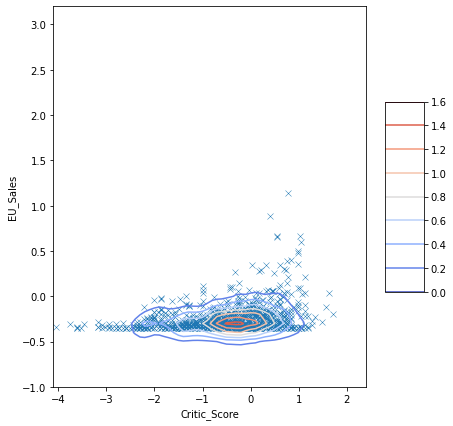

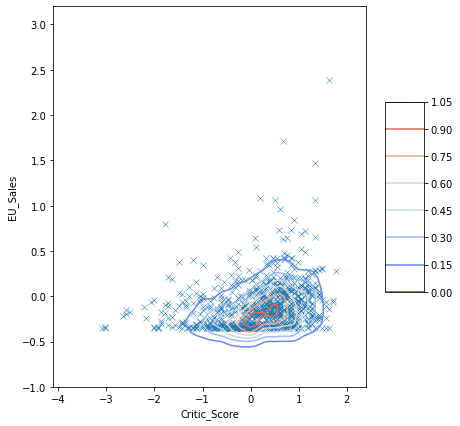

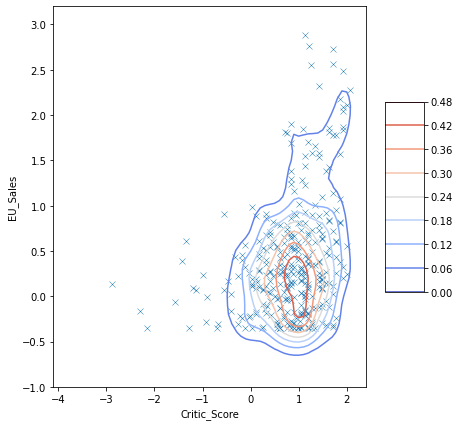

In [142]:
for cl in range(0, 3):

    tr_data = training_data[training_data["cluster"] == cl]
    kde = KernelDensity(bandwidth=bandwidths_for_classes[cl], kernel="gaussian")\
        .fit(tr_data[["Critic_Score", second_sales]])

    X = np.arange(-4.1, 2.5, 0.1).tolist()
    Y = np.arange(-1, 3.3, 0.1).tolist()
    X, Y = np.meshgrid(X, Y)

    inp = np.vstack((X.ravel(), Y.ravel())).T

    result = np.exp(kde.score_samples(inp))
    result = np.reshape(result, X.shape)

    fig = plt.figure()
    sns.scatterplot(data=tr_data, x="Critic_Score", y=second_sales, marker='x')
    p = plt.contour(X, Y, result, cmap='coolwarm')
    fig.colorbar(p, shrink=0.5, aspect=5)
    plt.show()

#### Prepare KDEs objects

In [143]:
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian")\
    .fit(tr_data_cl0[["Critic_Score", second_sales]])

tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian")\
    .fit(tr_data_cl1[["Critic_Score", second_sales]])

tr_data_cl2 = training_data[training_data["cluster"] == 2]
kde_cl2 = KernelDensity(bandwidth=bandwidths_for_classes[2], kernel="gaussian")\
    .fit(tr_data_cl2[["Critic_Score", second_sales]])

#### Perform classification - training dataset

In [144]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(training_data[["Critic_Score", second_sales]]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(training_data[["Critic_Score", second_sales]]))
kde_cl2_scores = np.exp(kde_cl2.score_samples(training_data[["Critic_Score", second_sales]]))

for index, row in training_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index], kde_cl2_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(training_data.index))



0.637291280148423


#### Perform classification - testing dataset

In [145]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(testing_data[["Critic_Score", second_sales]]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(testing_data[["Critic_Score", second_sales]]))
kde_cl2_scores = np.exp(kde_cl2.score_samples(testing_data[["Critic_Score", second_sales]]))

for index, row in testing_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index], kde_cl2_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(testing_data.index))



0.6233766233766234
